# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** [Ahmad Musthofanur]
- **Email:** [musthofanoers@gmail.com]
- **ID Dicoding:** [mvstofa]

## Import Semua Packages/Library yang Digunakan

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from tqdm import tqdm
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [4]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [5]:
# ini menonaktifkan warning yang mungkin muncul, seperti warning FutureWarning.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [7]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"parinduri","key":"b2b75f449dad72e1b27392c98ef7073c"}'}

In [8]:
import os
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d misrakahmed/vegetable-image-dataset
!unzip vegetable-image-dataset.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Vegetable Images/train/Radish/0001.jpg  
  inflating: Vegetable Images/train/Radish/0002.jpg  
  inflating: Vegetable Images/train/Radish/0003.jpg  
  inflating: Vegetable Images/train/Radish/0004.jpg  
  inflating: Vegetable Images/train/Radish/0005.jpg  
  inflating: Vegetable Images/train/Radish/0006.jpg  
  inflating: Vegetable Images/train/Radish/0007.jpg  
  inflating: Vegetable Images/train/Radish/0008.jpg  
  inflating: Vegetable Images/train/Radish/0009.jpg  
  inflating: Vegetable Images/train/Radish/0010.jpg  
  inflating: Vegetable Images/train/Radish/0011.jpg  
  inflating: Vegetable Images/train/Radish/0012.jpg  
  inflating: Vegetable Images/train/Radish/0013.jpg  
  inflating: Vegetable Images/train/Radish/0014.jpg  
  inflating: Vegetable Images/train/Radish/0015.jpg  
  inflating: Vegetable Images/train/Radish/0016.jpg  
  inflating: Vegetable Images/train/Radish/0017.jpg  
  inflating: Vegetable 

In [9]:
dataset_dir = 'Vegetable Images'

# Cek struktur folder
for root, dirs, files in os.walk(dataset_dir):
    print(f"Root: {root}")
    print(f"Subfolders: {dirs}")
    print(f"Files: {len(files)}")
    break  # Hanya cek satu level pertama untuk struktur folder

Root: Vegetable Images
Subfolders: ['train', 'test', 'validation']
Files: 0


In [10]:
import os
from PIL import Image

base_root = "/content/Vegetable Images"
folders = ['train', 'test', 'validation']

for folder in folders:
    path = os.path.join(base_root, folder)
    total_images = 0
    resolutions = {}

    print(f"\n📂 Folder: {folder}")
    for category in os.listdir(path):
        category_path = os.path.join(path, category)
        if os.path.isdir(category_path):
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                try:
                    with Image.open(img_path) as img:
                        total_images += 1
                        resolution = img.size  # (width, height)
                        resolutions[resolution] = resolutions.get(resolution, 0) + 1
                except Exception as e:
                    print(f"❌ Gagal baca {img_path}: {e}")

    print(f"Total gambar: {total_images}")
    print("Resolusi yang ditemukan:")
    for res, count in resolutions.items():
        print(f"  {res}: {count} gambar")


📂 Folder: train
Total gambar: 15000
Resolusi yang ditemukan:
  (224, 224): 14994 gambar
  (224, 210): 1 gambar
  (224, 211): 1 gambar
  (224, 198): 1 gambar
  (224, 193): 1 gambar
  (224, 200): 1 gambar
  (224, 205): 1 gambar

📂 Folder: test
Total gambar: 3000
Resolusi yang ditemukan:
  (224, 224): 2999 gambar
  (224, 207): 1 gambar

📂 Folder: validation
Total gambar: 3000
Resolusi yang ditemukan:
  (224, 224): 2998 gambar
  (224, 187): 1 gambar
  (224, 223): 1 gambar


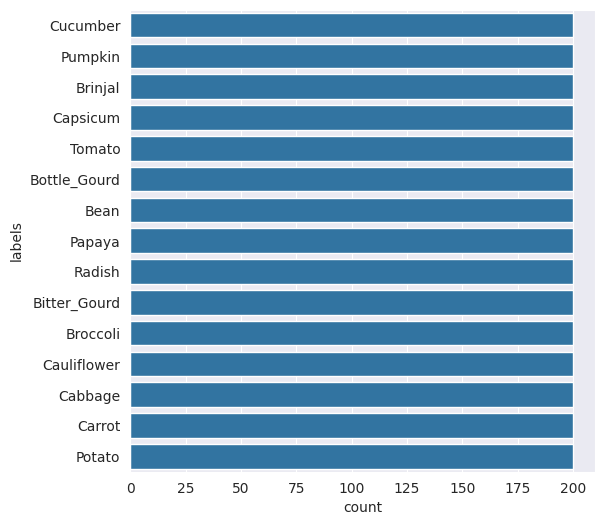

In [11]:
# Definisikan path sumber
vegetable_path = "/content/Vegetable Images/test/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(vegetable_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

#### Split Dataset

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation hanya untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Rescaling untuk validation dan test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Train data loader
train_generator = train_datagen.flow_from_directory(
    'Vegetable Images/train',
    target_size=(224, 224),
    batch_size=64,
    color_mode="rgb",  # Kalau mau pakai rgb
    class_mode='categorical',
    shuffle=True
)

# Validation data loader
validation_generator = val_test_datagen.flow_from_directory(
    'Vegetable Images/validation',
    target_size=(224, 224),
    batch_size=64,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)

# Test data loader
test_generator = val_test_datagen.flow_from_directory(
    'Vegetable Images/test',
    target_size=(224, 224),
    batch_size=1,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)


Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


## Modelling

In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout

# Load base model MobileNetV2
base_model = MobileNetV2(
    input_shape=(224, 224, 3),  # Ukuran input gambar
    include_top=False,          # Tidak menggunakan layer top (klasifikasi asli)
    weights='imagenet'          # Menggunakan bobot yang sudah dilatih pada ImageNet
)

# Bekukan layer-layer base model agar tidak dilatih ulang
base_model.trainable = False

# Bangun model dengan Sequential
model = Sequential([
    base_model,  # MobileNetV2 sebagai feature extractor

    # Tambahkan layer Conv2D
    Conv2D(32, (3, 3), activation='relu', padding='same'),  # Layer konvolusi pertama
    MaxPooling2D(pool_size=(2, 2)),  # Pooling layer pertama

    # Tambahkan layer Conv2D lagi
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Layer konvolusi kedua
    MaxPooling2D(pool_size=(2, 2)),  # Pooling layer kedua

    # Global Average Pooling untuk mereduksi dimensi
    GlobalAveragePooling2D(),

    # Dropout layer untuk regularisasi
    Dropout(0.5),

    # Fully connected layer
    Dense(128, activation='relu'),

    # Output layer untuk 15 kelas (ganti sesuai jumlah kelas)
    Dense(15, activation='softmax')
])

# Ringkasan model
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,655,407 (10.13 MB)

 Trainable params: 397,423 (1.52 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping callback untuk menghentikan training jika validasi loss tidak membaik selama beberapa epoch
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# ModelCheckpoint untuk menyimpan model terbaik berdasarkan val_loss
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/best_model.h5',  # simpan di Google Drive
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Tentukan batch_size
batch_size = 64

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model dengan callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,
    callbacks=[early_stopping, checkpoint]  # Menambahkan callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.6588 - loss: 1.0762
Epoch 1: val_loss improved from inf to 0.04964, saving model to /content/drive/MyDrive/best_model.h5


234/234 ━━━━━━━━━━━━━━━━━━━━ 211s 842ms/step - accuracy: 0.6595 - loss: 1.0738 - val_accuracy: 0.9847 - val_loss: 0.0496
Epoch 2/10
  1/234 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.9844 - loss: 0.0663

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 0.04964
234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9844 - loss: 0.0663 - val_accuracy: 0.9847 - val_loss: 0.0516
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.9611 - loss: 0.1332
Epoch 3: val_loss improved from 0.04964 to 0.04397, saving model to /content/drive/MyDrive/best_model.h5


234/234 ━━━━━━━━━━━━━━━━━━━━ 262s 910ms/step - accuracy: 0.9611 - loss: 0.1331 - val_accuracy: 0.9878 - val_loss: 0.0440
Epoch 4/10
  1/234 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 1.0000 - loss: 0.0075
Epoch 4: val_loss did not improve from 0.04397
234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 0.9881 - val_loss: 0.0489
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.9761 - loss: 0.0807
Epoch 5: val_loss improved from 0.04397 to 0.02995, saving model to /content/drive/MyDrive/best_model.h5


234/234 ━━━━━━━━━━━━━━━━━━━━ 185s 791ms/step - accuracy: 0.9761 - loss: 0.0807 - val_accuracy: 0.9935 - val_loss: 0.0300
Epoch 6/10
  1/234 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 1.0000 - loss: 0.0578
Epoch 6: val_loss improved from 0.02995 to 0.02908, saving model to /content/drive/MyDrive/best_model.h5


234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 1.0000 - loss: 0.0578 - val_accuracy: 0.9939 - val_loss: 0.0291
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.9797 - loss: 0.0880
Epoch 7: val_loss improved from 0.02908 to 0.02471, saving model to /content/drive/MyDrive/best_model.h5


234/234 ━━━━━━━━━━━━━━━━━━━━ 186s 796ms/step - accuracy: 0.9797 - loss: 0.0880 - val_accuracy: 0.9918 - val_loss: 0.0247
Epoch 8/10
  1/234 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 1.0000 - loss: 0.0045
Epoch 8: val_loss improved from 0.02471 to 0.02211, saving model to /content/drive/MyDrive/best_model.h5


234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.9925 - val_loss: 0.0221
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.9825 - loss: 0.0654
Epoch 9: val_loss improved from 0.02211 to 0.01453, saving model to /content/drive/MyDrive/best_model.h5


234/234 ━━━━━━━━━━━━━━━━━━━━ 191s 779ms/step - accuracy: 0.9825 - loss: 0.0654 - val_accuracy: 0.9952 - val_loss: 0.0145
Epoch 10/10
  1/234 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.9844 - loss: 0.0367
Epoch 10: val_loss did not improve from 0.01453
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9844 - loss: 0.0367 - val_accuracy: 0.9952 - val_loss: 0.0156
Restoring model weights from the end of the best epoch: 9.


In [15]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.9931 - loss: 0.0351
Test Accuracy: 99.37%
Test Loss: 0.0317


In [16]:
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 240ms/step - accuracy: 0.9960 - loss: 0.0132
Validation Accuracy: 99.53%
Validation Loss: 0.0143


In [19]:
from tensorflow.keras.models import load_model
# Load best model
model = load_model('/content/drive/MyDrive/best_model.h5')
# Export ke format SavedModel (.pb)
model.export('/content/drive/MyDrive/best_model_pb_format')

Saved artifact at '/content/drive/MyDrive/best_model_pb_format'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  139842540432720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139842540433104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139842540433488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139842540433296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139842540429264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139842540434640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139842540435024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139842540435408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139842540435216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139842540431568: TensorSpec(shape=(), dtype=tf.resource

## Evaluasi dan Visualisasi

In [20]:
# Mengambil data akurasi dan loss dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

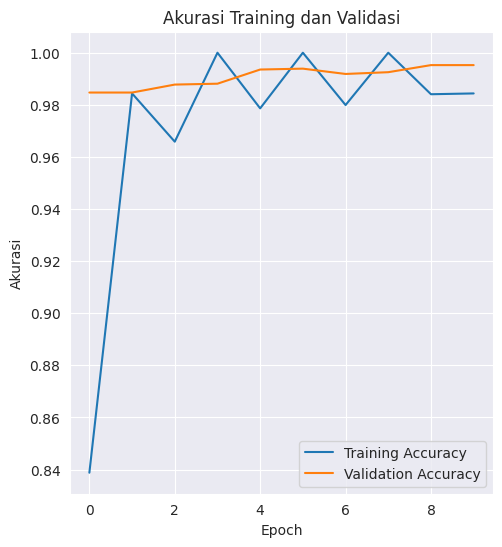

In [21]:
# Membuat plot untuk akurasi
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Akurasi Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

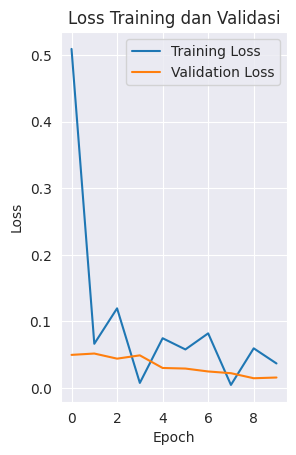

In [22]:
# Membuat plot untuk loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Konversi Model

In [23]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [24]:
import tensorflow as tf

# Path model .pb
saved_model_dir = '/content/drive/MyDrive/best_model_pb_format'

# Buat converter
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

# Optimasi agar lebih ringan
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Konversi ke tflite
tflite_model = converter.convert()

# Simpan ke file
with open('/content/drive/MyDrive/best_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model berhasil dikonversi ke .tflite")

Model berhasil dikonversi ke .tflite


In [25]:
import tensorflowjs as tfjs
from tensorflow.keras.models import load_model

# Load model dari .h5
model = load_model('/content/drive/MyDrive/best_model.h5')

# Konversi ke format tfjs dan simpan ke folder tujuan
tfjs.converters.save_keras_model(model, '/content/drive/MyDrive/tfjs_model_keras')

failed to lookup keras version from the file,
    this is likely a weight only file


In [34]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [36]:
!pipreqs '/content/drive/MyDrive' --force --scan-notebooks

Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requirements file in /content/drive/MyDrive/requirements.txt


## Inference (Optional)

In [37]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/best_model.h5')

In [50]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = '/content/Vegetable Images/test/Carrot/1001.jpg'  # Ganti dengan path ke gambar
img = image.load_img(img_path, target_size=(224, 224))  # Sesuai ukuran input model
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Tambah dimensi batch
img_array = img_array / 255.0  # Normalisasi (sama seperti saat training)


In [51]:
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]
confidence = np.max(predictions) * 100


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [52]:
class_labels = list(test_generator.class_indices.keys())
print(f"Predicted Class: {class_labels[predicted_class]} ({confidence:.2f}% confidence)")


Predicted Class: Carrot (100.00% confidence)


In [53]:
# Ambil nama label kelas dari test_generator
class_labels = list(test_generator.class_indices.keys())
label = class_labels[predicted_class]

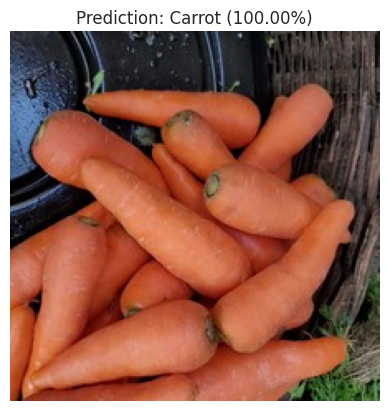

In [54]:
# Tampilkan gambar dan prediksi
plt.imshow(img)
plt.title(f'Prediction: {label} ({confidence:.2f}%)')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


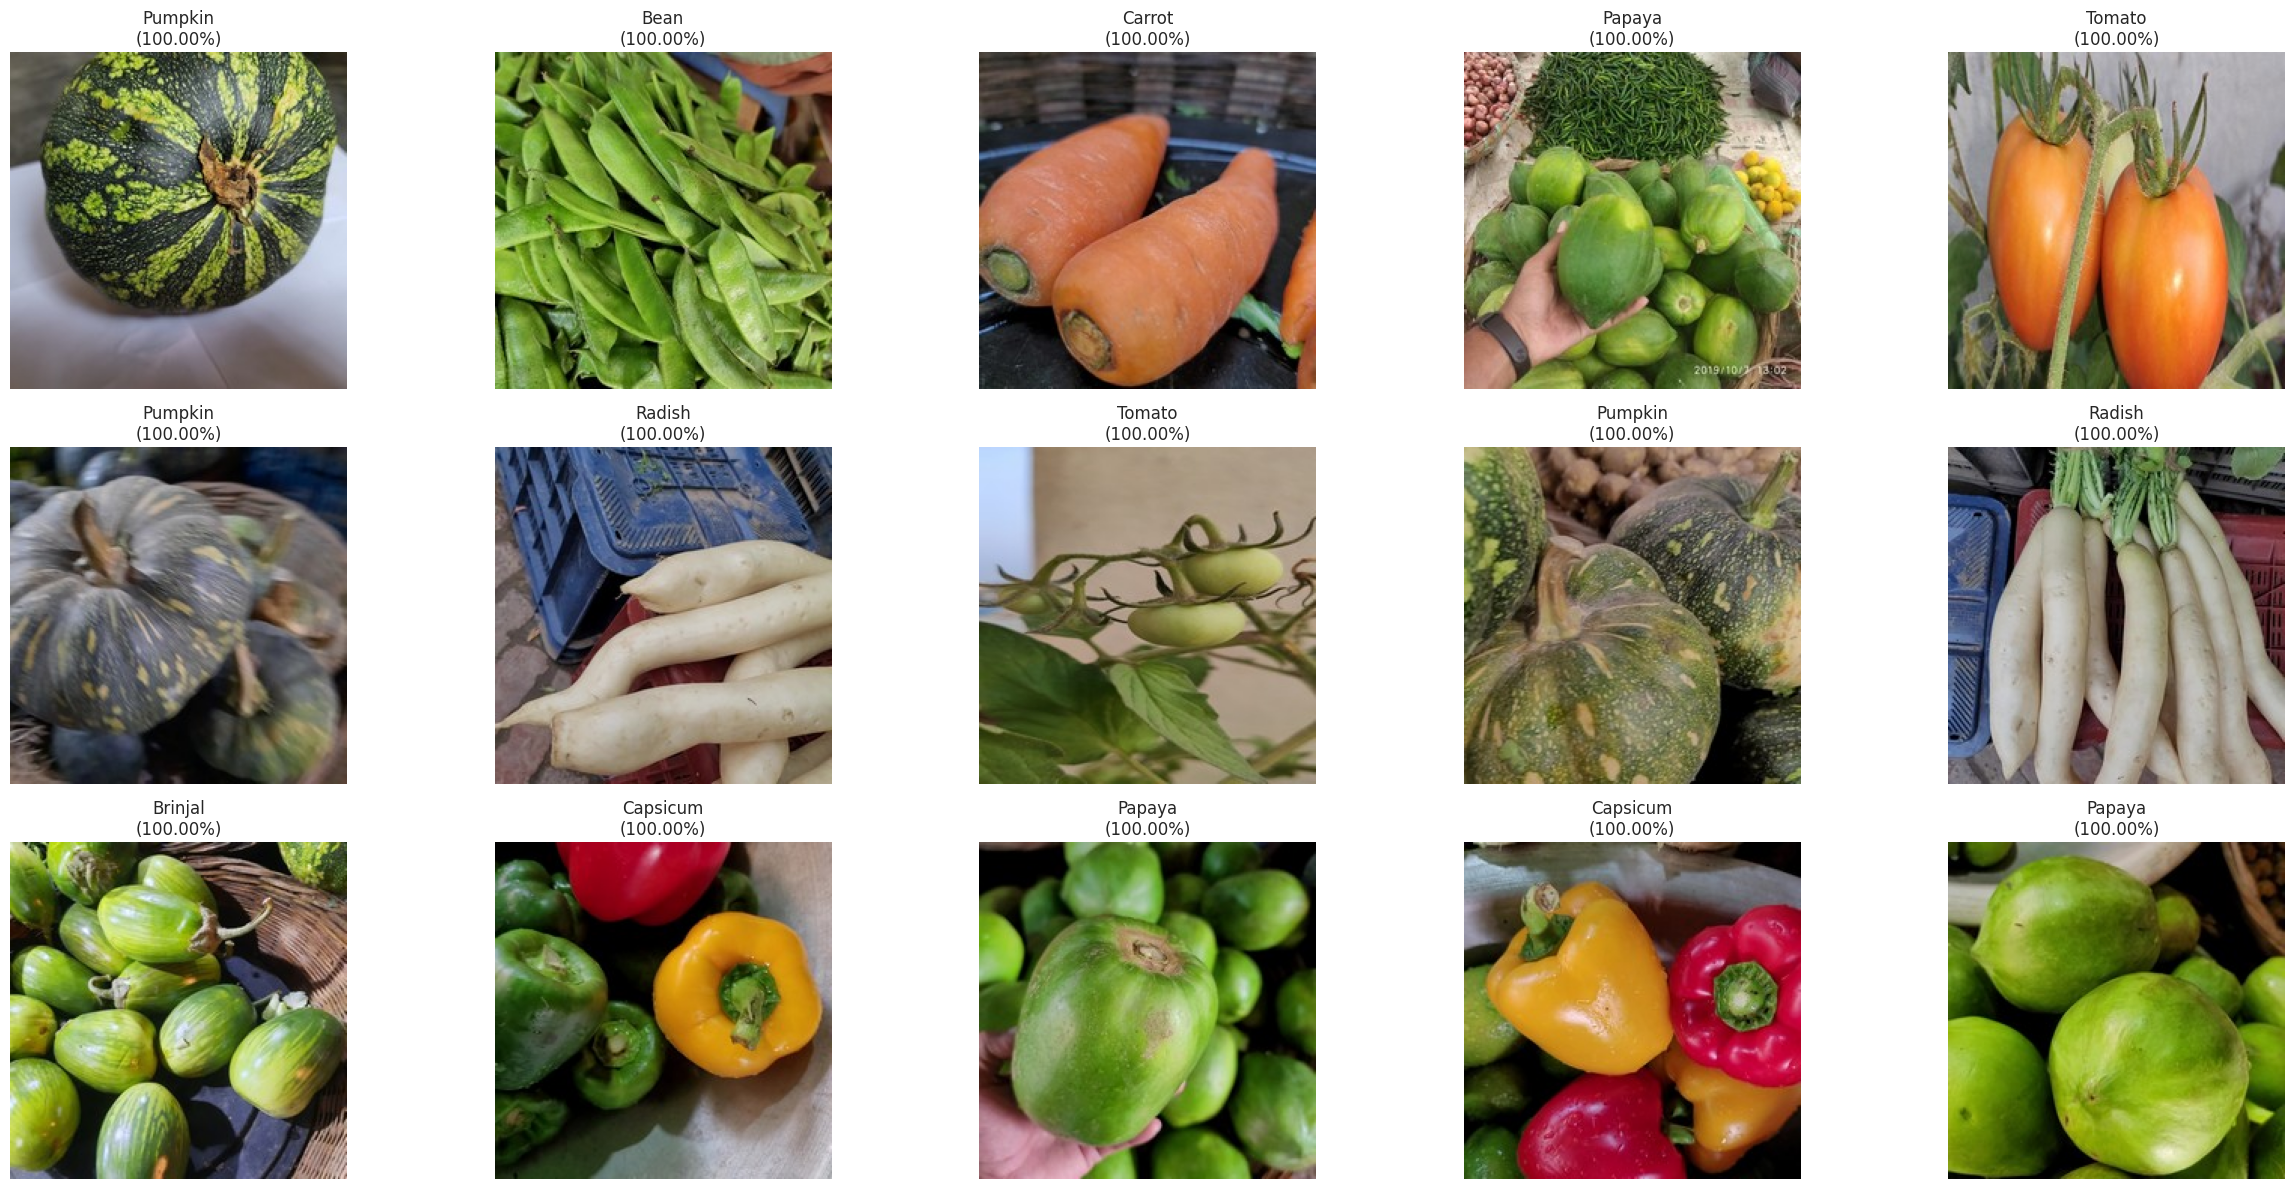

In [57]:
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model

# Load model terbaik
model = load_model('/content/drive/MyDrive/best_model.h5')

# Ambil label kelas dari test_generator
class_labels = list(test_generator.class_indices.keys())

# Ambil path semua gambar dari direktori test
test_dir = 'Vegetable Images/test'
image_paths = []

for class_name in class_labels:
    class_path = os.path.join(test_dir, class_name)
    image_filenames = os.listdir(class_path)
    for filename in image_filenames:
        if filename.lower().endswith(('jpg', 'jpeg', 'png')):
            image_paths.append(os.path.join(class_path, filename))

# Pilih 15 gambar acak
random.shuffle(image_paths)
selected_images = image_paths[:15]

# Siapkan plotting
plt.figure(figsize=(25, 12))

for i, img_path in enumerate(selected_images):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Prediksi
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions) * 100
    predicted_label = class_labels[predicted_class]

    # Plot gambar dan label
    plt.subplot(3, 5, i+1)
    plt.imshow(img)
    plt.title(f'{predicted_label}\n({confidence:.2f}%)')
    plt.axis('off')

plt.tight_layout()
plt.show()
